In [16]:
import pandas as pd
import sklearn as sk
import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [17]:
data = pd.read_csv("../data/Final_dataset.csv")[:10000]
# data.isna().any()
data.columns

Index(['Unnamed: 0', 'Value Date', 'Trade Name', 'Trade Currency',
       'Zero Rate Shock', 'TV', 'Expiry Bucket', 'Expiry Date', 'Tenor Bucket',
       'Vega', 'Vols', 'Start Date', 'Tenor', 'Swap Rate', 'pay_frequency',
       'maturity', 'lower_bound', 'upper_bound', 'Daily_Diff_STD',
       'Weekly_Diff_STD', 'Monthly_Diff_STD', 'Mean_CMS', 'STD_CMS', 'Max_CMS',
       'Min_CMS', 'Proportion_Within_Range'],
      dtype='object')

In [18]:
# drop those unnecessary columns from the original table.
y = data["Vega"]
X = data.drop(["Vega", "Unnamed: 0", "Value Date", "Trade Name", "Trade Currency", \
               "Expiry Bucket", "Expiry Date", "Tenor Bucket", "Start Date", "Tenor"], axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train

,Zero Rate Shock,TV,Vols,Swap Rate,pay_frequency,maturity,lower_bound,upper_bound,Daily_Diff_STD,Weekly_Diff_STD,Monthly_Diff_STD,Mean_CMS,STD_CMS,Max_CMS,Min_CMS,Proportion_Within_Range
9254,-25,-625704.723057,0.455123,1.703876,4,10,0.0046,0.0417,0.307127,0.181332,0.450734,2.488097,0.639738,4.173166,1.042757,0.999839
1561,-50,-653383.194905,0.300949,1.703876,3,10,0.0042,0.0379,0.332305,0.194263,0.476413,2.451733,0.770452,4.239414,0.251352,0.966822
1670,-25,-216232.034537,0.102335,0.475481,3,5,0.0046,0.0417,0.307127,0.181332,0.450734,2.488097,0.639738,4.173166,1.042757,0.999839
6087,-10,-616280.686696,0.166069,0.983615,4,10,0.0046,0.0417,0.307127,0.181332,0.450734,2.488097,0.639738,4.173166,1.042757,0.999839
6669,50,-565587.194836,0.370352,1.703876,4,10,0.0046,0.0417,0.307127,0.181332,0.450734,2.488097,0.639738,4.173166,1.042757,0.999839
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5734,75,-527747.656424,0.067940,0.350458,2,10,0.0042,0.0379,0.332305,0.194263,0.476413,2.451733,0.770452,4.239414,0.251352,0.966822
5191,10,-213858.452424,0.295344,1.554418,2,5,0.0042,0.0379,0.332305,0.194263,0.476413,2.451733,0.770452,4.239414,0.251352,0.966822
5390,-25,-217879.517567,0.345775,1.703876,2,5,0.0044,0.0397,0.311437,0.184641,0.457632,2.487190,0.696338,4.239429,0.616615,0.989692
860,25,-592893.494543,0.116034,0.806490,2,10,0.0044,0.0397,0.311437,0.184641,0.457632,2.487190,0.696338,4.239429,0.616615,0.989692


In [19]:
# ! pip install optuna

In [20]:
#  ! pip install xgboost

# XGboosting

In [21]:
def mean_absolute_percentage_error(y_true, y_pred):
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [22]:
from xgboost import XGBRegressor
import xgboost as xgb
import optuna
# data_xgb = data.copy()
# trainset = xgb.DMatrix(X_train, label = y_train)
# testset = xgb.DMatrix(X_test, label = y_test)

def objective(trial):
    # Define hyperparameters to search
    param = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',

        'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
        'verbosity': 0,
        #'tree_method': 'gpu_hist',
    }

    # Initialize XGBoost regressor with the suggested parameters
    xgb = XGBRegressor(**param)

    # Fit the model on training data
    xgb.fit(X_train, y_train)

    # Predict on the validation set
    y_pred = xgb.predict(X_test)

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    return rmse



X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state= 3292234861)
# Perform hyperparameter optimization using Optuna
study = optuna.create_study(direction = 'minimize')
study.optimize(objective, n_trials=50)

# Print the best trial and parameters found
print("Best trial:")
best_trial = study.best_trial
print(f"  Value: {best_trial.value}")
print("  Params: ")
for key, value in best_trial.params.items():
    print(f"    {key}: {value}")

# Use the best parameters to train the final model
#
best_params = best_trial.params
xgb_best = XGBRegressor(**best_params)
xgb_best.fit(X_train, y_train)

# Make predictions on the test set
y_pred_test = xgb_best.predict(X_test)

# Calculate RMSE on the test set
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
print("Test RMSE:", rmse_test)


# 5.4
# Best trial:
#   Value: 17.886331714893714
#   Params: 
#     n_estimators: 258
#     max_depth: 5
#     learning_rate: 0.05953502409308761
#     subsample: 0.8211283885017797
#     colsample_bytree: 0.6023607779232046
#     reg_alpha: 3.599233335627732
#     reg_lambda: 3.134589585196354
# Test RMSE: 17.886331714893714
# MSE = 324 < Random Forest

# 5.6
# Best trial:
#   Value: 17.870080003330035
#   Params: 
#     n_estimators: 946
#     max_depth: 6
#     learning_rate: 0.010819755496783368
#     subsample: 0.7327681509788211
#     colsample_bytree: 0.8354071139897575
#     reg_alpha: 9.726499576001782
#     reg_lambda: 6.127266393195882
# Test RMSE: 17.870080003330035


[I 2024-05-29 17:16:10,602] A new study created in memory with name: no-name-d2f371ea-1787-4802-b81b-e54f6977a03c


[I 2024-05-29 17:16:27,568] Trial 0 finished with value: 26.709918077259722 and parameters: {'n_estimators': 1909, 'max_depth': 11, 'learning_rate': 0.019452536503960588, 'subsample': 0.8815243067611722, 'colsample_bytree': 0.6280279737609854, 'reg_alpha': 4.1828577508810145, 'reg_lambda': 9.441987320472151}. Best is trial 0 with value: 26.709918077259722.
[I 2024-05-29 17:16:33,554] Trial 1 finished with value: 31.51992979690241 and parameters: {'n_estimators': 1956, 'max_depth': 4, 'learning_rate': 0.06596877416628921, 'subsample': 0.9995229185905651, 'colsample_bytree': 0.7005703280927699, 'reg_alpha': 9.598573196967386, 'reg_lambda': 2.402586729064259}. Best is trial 0 with value: 26.709918077259722.
[I 2024-05-29 17:16:36,231] Trial 2 finished with value: 28.258297081412742 and parameters: {'n_estimators': 570, 'max_depth': 6, 'learning_rate': 0.07788547520499316, 'subsample': 0.6202371059705066, 'colsample_bytree': 0.9310973572235972, 'reg_alpha': 8.262832537686252, 'reg_lambda':

Best trial:
  Value: 26.333607904481678
  Params: 
    n_estimators: 1366
    max_depth: 10
    learning_rate: 0.011532067255216237
    subsample: 0.8491331872122521
    colsample_bytree: 0.7522507149450635
    reg_alpha: 6.735984595335068
    reg_lambda: 7.820908582924565
Test RMSE: 26.333607904481678


In [26]:
y_pred_test_xgb = xgb_best.predict(X_test)
# xgb_loss = mean_absolute_percentage_error(y_test, y_pred_test_xgb)
# print(f"ERROR PERCENT = { mean_absolute_percentage_error(y_test, y_pred_test_xgb) }% ")

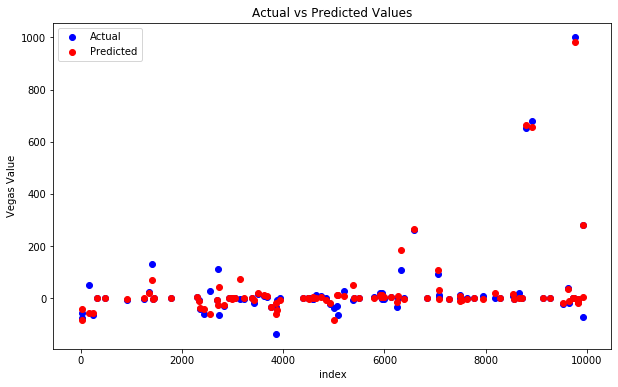

In [29]:
plt.figure(figsize=(10, 6))
plt.scatter(X_test.index[:100], y_test[:100], color='blue', label='Actual')
plt.scatter(X_test.index[:100], y_pred_test_xgb[:100] , color='red', label='Predicted')
plt.title('Actual vs Predicted Values')
plt.xlabel('index')
plt.ylabel('Vegas Value')
plt.legend()
plt.show()